In [54]:
import torch
import torch.utils.data as data
#import torchvision
#import torchvision.transforms as transforms


import sys, os
sys.path.insert(0, '/home/daniil/repos/pytorch-segmentation-detection/vision/')
sys.path.append('/home/daniil/repos/pytorch-segmentation-detection/')


from pytorch_segmentation_detection.utils.detection import (compute_bboxes_ious,
                                                            convert_bbox_topleft_xywh_tensor_to_center_xywh,
                                                            convert_bbox_center_xywh_tensor_to_xyxy,
                                                            convert_bbox_center_xywh_tensor_to_topleft_xywh,
                                                            display_bboxes_center_xywh)
          
# put this into utils.detection
from torchvision.datasets import CocoDetection


class PascalVOCDetection(data.Dataset):
    
    def __init__(self, images_folder_path, annotation_json, input_img_size=600):
        
        self.input_size = input_img_size
        self.images_folder_path = images_folder_path
        self.annotation_json = annotation_json
        
        self.pascal_cocolike_db = CocoDetection(annFile=annotation_json,
                                               root=images_folder_path)
        
    def __len__(self):
        
        return len(self.pascal_cocolike_db)
    
    def __getitem__(self, idx):
        
        pil_img, cocolike_detection_annotations = self.pascal_cocolike_db[idx]
        
        bboxes_locations_topleft_xywh = map(lambda cocolike_dict: cocolike_dict['bbox'], cocolike_detection_annotations)
        bboxes_classes = map(lambda cocolike_dict: cocolike_dict['category_id'], cocolike_detection_annotations)
        
        # Getting the xywh coordinates and converting them to xyxy
        bboxes_locations_topleft_xywh = torch.FloatTensor( bboxes_locations_topleft_xywh )
        #TODO: take this part out to transformations object
        ground_truth_boxes_center_xywh = convert_bbox_topleft_xywh_tensor_to_center_xywh( bboxes_locations_topleft_xywh )
        
        ground_truth_labels = torch.LongTensor( bboxes_classes )
        
        # TODO: run the transformation stack here and conclude
        # with the .encode() of anchorbox generator
        
        return pil_img, ground_truth_boxes_center_xywh, ground_truth_labels
    
    
dataset = PascalVOCDetection(annotation_json='/home/daniil/projects/pascal/PASCAL_VOC/pascal_val2012.json',
                             images_folder_path='/home/daniil/projects/pascal/dataset/VOCdevkit/VOC2012/JPEGImages/')

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [140]:
import math
import numpy as np


def get_feature_map_size(input_img_size, stride):
    """
    Given an image size and stride of a network, computes the output feature map size.
    """
    
    input_size = np.asarray(input_img_size).astype(np.float)

    feature_map_size = input_size / stride
    
    return np.floor(feature_map_size).astype(np.int)
    

class AnchorBoxGenerator():
    """
    Anchor box generator class that takes care of generation of anchor
    boxes for each element of resulted feature map. Feature map size is
    computed given the input image size, it is equal to the the size of the input
    image subsampled with a ```stirde``` parameter.
    
    The class accepts ```anchor_areas```, ```aspect_ratios``` parameters.
    All possible pairs of these combinations are generated and result in
    ```size(anchor_areas) * size(aspect_ratios) ``` anchor boxes for each
    element of resulted feature map.
    """
    
    def __init__(self,
                 input_image_size=(600, 600),
                 anchor_areas=[128*128, 256*256, 512*512],
                 aspect_ratios=[1/2., 1/1., 2/1.],
                 stride=16
                ):
        
        self.input_image_size = input_image_size
        self.anchor_areas = anchor_areas
        self.aspect_ratios = aspect_ratios
        self.stride = stride
        
        # Precomputing anchor boxes positions
        
        self.precompute_anchor_boxes(input_image_size)
        
        
    def get_anchor_boxes_sizes(self):
        """
        Computes all pairs of ```anchor_areas``` and ```aspect_ratios``` parameters
        resulting in bounding boxes of various sizes. Overall, the number of boxes is
        equal to ```size(anchor_areas) * size(aspect_ratios) ```.
        """
        
        anchor_boxes_sizes = []
        
        for current_anchor_area in self.anchor_areas:
            
            for current_aspect_ratio in self.aspect_ratios:
                
                # Given:
                # aspect_ratio = w / h
                # anchor_area = w * h
                # To find:
                # w and h
                # w = sqrt( aspect_ratio * anchor_area ) = sqrt( (w*w*h) / h ) = sqrt(w*w) = w
                
                w = math.sqrt( current_aspect_ratio * current_anchor_area )
                h = current_anchor_area / w
                
                anchor_boxes_sizes.append((w, h))
        
        # Adding a dummy dimension here in order to easily use .repeat() later
        return np.expand_dims( np.asarray(anchor_boxes_sizes), axis=0 )
    
    
    def get_anchor_boxes_center_coordinates(self, input_size):
        """
        Computes the coordinates of centers of bounding boxes of each element
        of feature map with respect to the input image coordinate system.
        We will need this to compute intersections of groundtruth boxes with 
        our generated anchor boxes which we will need to classify each anchor box
        as a positive/negative/ambigious.
        """
        
        feature_map_height, feature_map_width = get_feature_map_size(input_size, stride=self.stride)

        meshgrid_height, meshgrid_width = np.meshgrid(range(feature_map_height), range(feature_map_width))

        # Getting coordinates of centers of all the grid cells of the feature map
        anchor_coordinates_feature_map = zip(meshgrid_height.flatten(), meshgrid_width.flatten())
        anchor_coordinates_feature_map = np.asarray( anchor_coordinates_feature_map )
        anchor_coordinates_feature_map = anchor_coordinates_feature_map + 0.5

        anchor_coordinates_input = anchor_coordinates_feature_map * self.stride
        
        return np.expand_dims( anchor_coordinates_input, axis=1 )
        
    
    def precompute_anchor_boxes(self, input_size):
        """
        Function that combines all the previous functions to compute all anchor boxes
        with their coordinates with respect to the input image's coordinate system.
        
        Number of anchor boxes can be computed as:
         ```size(anchor_areas) * size(aspect_ratios) * (input_height / stride) * (input_width / stride) ```
         
        These precomputed anchor boxes are used later on to compute target values
        for each image.
        """
        
        anchor_boxes_sizes = self.get_anchor_boxes_sizes()
        anchor_boxes_center_coordinates = self.get_anchor_boxes_center_coordinates(input_size)
        
        anchor_boxes_sizes_number = anchor_boxes_sizes.shape[1]
        anchor_boxes_center_coordinates_number = anchor_boxes_center_coordinates.shape[0]
        
        anchor_boxes_center_coordinates_repeated = anchor_boxes_center_coordinates.repeat(anchor_boxes_sizes_number, axis=1)
        anchor_boxes_sizes_repeated =  anchor_boxes_sizes.repeat(anchor_boxes_center_coordinates_number, axis=0)
        
        anchor_boxes = np.dstack((anchor_boxes_center_coordinates_repeated, anchor_boxes_sizes_repeated))
        
        anchor_boxes = anchor_boxes.reshape((-1, 4))
        
        self.anchor_boxes = torch.FloatTensor( anchor_boxes ).clone()
    
    def encode(self, ground_truth_boxes_center_xywh, ground_truth_labels):
                
        # (N, 4)
        anchor_boxes_center_xywh = anchor_box_generator.anchor_boxes

        # --- Conversion stage
        # Converting anchor boxes and groudtruth boxes into xyxy format
        # in order to compute the intersection over union later on

        anchor_boxes_xyxy = convert_bbox_center_xywh_tensor_to_xyxy(anchor_boxes_center_xywh)
        ground_truth_boxes_xyxy = convert_bbox_center_xywh_tensor_to_xyxy(ground_truth_boxes_center_xywh)

        # --- Matching stage
        # Computing intersection over union between all pairs of anchor boxes
        # and groundtruth boxes
        
        # (N, M)
        ious = compute_bboxes_ious(anchor_boxes_xyxy, ground_truth_boxes_xyxy)

        # Getting ground truth box with the biggest intersection for
        # each anchor box. -- we get ids here
        # (N,)
        anchor_boxes_best_groundtruth_match_ious, anchor_boxes_best_groundtruth_match_ids = ious.max(1)

        # Here we actually extract the relevant groundtruth for each anchor box
        groundtruth_boxes_center_xywh_best_match_anchorwise = ground_truth_boxes_center_xywh[anchor_boxes_best_groundtruth_match_ids]

        # --- Regressing stage

        delta_xy = (groundtruth_boxes_center_xywh_best_match_anchorwise[:,:2]-anchor_boxes_center_xywh[:,:2]) / anchor_boxes_center_xywh[:,2:]
        delta_wh = torch.log(groundtruth_boxes_center_xywh_best_match_anchorwise[:,2:]/anchor_boxes_center_xywh[:,2:])

        target_deltas = torch.cat((delta_xy, delta_wh), dim=1)

        # Accounting for the background here
        target_labels = ground_truth_labels[anchor_boxes_best_groundtruth_match_ids] + 1

        target_labels[anchor_boxes_best_groundtruth_match_ious < 0.5] = 0

        ignore = (anchor_boxes_best_groundtruth_match_ious > 0.4) & (anchor_boxes_best_groundtruth_match_ious < 0.5)

        target_labels[ignore] = -1
        
        print(target_labels.shape)
        
        print((anchor_boxes_best_groundtruth_match_ious >= 0.5).sum())
        
        matched_anchors = anchor_boxes_center_xywh[torch.nonzero(anchor_boxes_best_groundtruth_match_ious >= 0.4), :]
        
        return target_deltas, target_labels, matched_anchors
        
        

In [141]:
anchor_box_generator = AnchorBoxGenerator()

In [142]:
anchor_box_generator.anchor_boxes.shape

torch.Size([12321, 4])

torch.Size([12321])
12


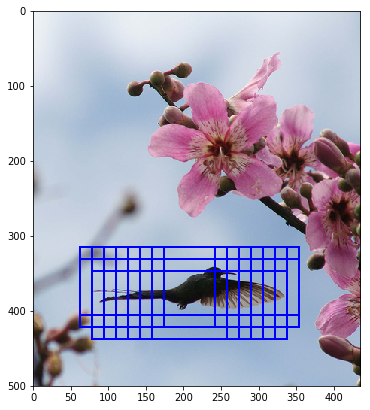

In [144]:
# make a sanity check -- visualize positive boxes and 

# 100
img, ground_truth_bboxes_center_xywh, ground_truth_bboxes_labels = dataset[100]

one, two, three = anchor_box_generator.encode(ground_truth_boxes_center_xywh=ground_truth_bboxes_center_xywh,
                                    ground_truth_labels=ground_truth_bboxes_labels)

three = three.squeeze(1)

display_bboxes_center_xywh(img, three)

In [145]:
ann = dataset.pascal_cocolike_db[100]
ann

(<PIL.Image.Image image mode=RGB size=436x500 at 0x7FD8ED235A90>,
 [{u'area': 15163,
   u'bbox': [79, 341, 257, 59],
   u'category_id': 3,
   u'id': 13461,
   u'ignore': 0,
   u'image_id': 2011000114,
   u'iscrowd': 0,
   u'segmentation': [[79, 341, 79, 400, 336, 400, 336, 341]]}])

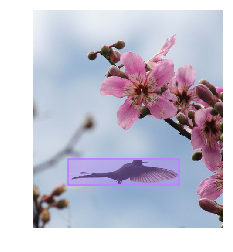

In [146]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(np.asarray(ann[0])); plt.axis('off')
ax = plt.gca()

dataset.pascal_cocolike_db.coco.showAnns(anns=ann[1])